<a href="https://colab.research.google.com/github/namm9an/Pairs-Trading-Strategy-with-RO/blob/main/streamlit_app_for_TPWRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00


2024-07-02 12:45:20.454 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-07-02 12:45:20.460 Session state does not function when running a script without `streamlit run`
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


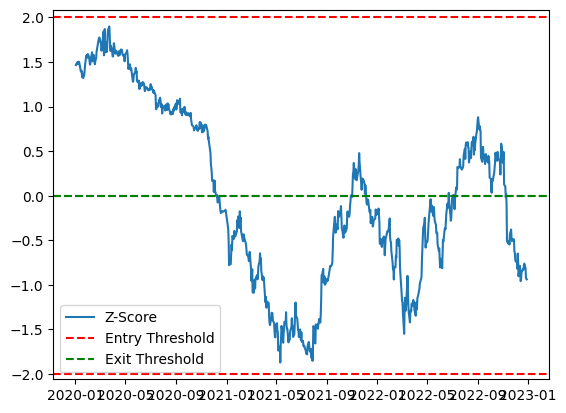

In [2]:
import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

st.title("Pairs Trading Strategy with Risk Optimization")

# Function to fetch stock data
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

# Input fields for user
st.sidebar.header("User Input Parameters")
ticker1 = st.sidebar.text_input("Stock 1 Ticker", "PETR4.SA")
ticker2 = st.sidebar.text_input("Stock 2 Ticker", "VALE3.SA")
start_date = st.sidebar.date_input("Start Date", pd.to_datetime("2020-01-01"))
end_date = st.sidebar.date_input("End Date", pd.to_datetime("2023-01-01"))

# Fetch data for the selected stocks
data1 = fetch_data(ticker1, start_date, end_date)
data2 = fetch_data(ticker2, start_date, end_date)

# Ensure both data series are of the same length
data = pd.DataFrame({ticker1: data1, ticker2: data2}).dropna()

# Calculate the spread
data['spread'] = data[ticker1] - data[ticker2]

# Display data
st.subheader("Price Data")
st.line_chart(data[[ticker1, ticker2]])

st.subheader("Spread")
st.line_chart(data['spread'])

# Cointegration test
def check_cointegration(stock1, stock2):
    coint_result = sm.tsa.stattools.coint(stock1, stock2)
    return coint_result

coint_result = check_cointegration(data[ticker1], data[ticker2])
st.write(f"Cointegration Test P-Value: {coint_result[1]}")

# Z-score calculation
def calculate_zscore(spread):
    spread_mean = spread.mean()
    spread_std = spread.std()
    zscore = (spread - spread_mean) / spread_std
    return zscore

data['zscore'] = calculate_zscore(data['spread'])

# Display Z-score
st.subheader("Z-Score of the Spread")
st.line_chart(data['zscore'])

# Trading signals
entry_threshold = st.sidebar.slider("Entry Z-Score Threshold", 1.0, 3.0, 2.0)
exit_threshold = st.sidebar.slider("Exit Z-Score Threshold", -1.0, 1.0, 0.0)

data['long_signal'] = (data['zscore'] < -entry_threshold).astype(int)
data['short_signal'] = (data['zscore'] > entry_threshold).astype(int)
data['exit_signal'] = (abs(data['zscore']) < exit_threshold).astype(int)

st.subheader("Trading Signals")
st.write(data[['long_signal', 'short_signal', 'exit_signal']])

# Plot signals
fig, ax = plt.subplots()
ax.plot(data.index, data['zscore'], label='Z-Score')
ax.axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
ax.axhline(-entry_threshold, color='r', linestyle='--')
ax.axhline(exit_threshold, color='g', linestyle='--', label='Exit Threshold')
ax.axhline(-exit_threshold, color='g', linestyle='--')
ax.legend()
st.pyplot(fig)

# Backtesting
st.subheader("Backtesting Results")
data['positions'] = data['long_signal'] - data['short_signal']
data['returns'] = data['spread'].pct_change() * data['positions'].shift()

cumulative_returns = (1 + data['returns']).cumprod() - 1
st.line_chart(cumulative_returns)

# Display summary
st.write("Cumulative Returns:", cumulative_returns[-1])

if st.sidebar.button("Run Full Analysis"):
    st.write("Full analysis results go here...")

